### Saluda Medical Data Analysis Task by Paul Tran 01 Feb 2021

> The data is in long format, and contains data recordings we are interested in (Value column). There are multiple entries for:
-	different patients (PatientID column)
-	the location the recording was taken at (Location column); 
-	the time that a recording was taken (Time column). 
 
> Your task is to, using your analytics tool of choice:
-	Load in the data
-	Explore and analyse the data as you see fit to understand and test whether, at each of the two Locations, Value changes systematically with Time compared to baseline (Time 0), and understand the nature of any trends in the data. A few points to note are:
  - We’re particularly interested in differences over the time period of 0 to ~15, although we’d also like to know about any changes beyond this time point.
  - We’re interested in whether there are consistent changes within patients, regardless of any baseline differences between patients.




### Data Exploration

In [131]:
## Import modules and packages

import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt


In [132]:
# Declare path to data 
path_home = "/content"
path_data = path_home + "/analysis_test_data.csv"

In [133]:
# Load data
df_data = pd.read_csv(path_data)
df_data.head()

,PatientID,Time,Location,Value
0,2,0,Loc2,72.806172
1,2,0,Loc1,1288.334928
2,2,3,Loc2,70.319241
3,2,3,Loc1,1219.907629
4,2,5,Loc2,62.295082


In [134]:
# Check the shape of the data
df_data.shape

(1772, 4)

There are 1772 rows of entries and 4 columns.

In [135]:
# Use describe to quickly glance at some distributions or data counts of the data
df_data.describe()

,PatientID,Time,Value
count,1772.000000,1772.000000,1724.000000
mean,76.582393,33.600451,364.797559
std,41.867413,33.564530,600.244881
min,2.000000,0.000000,0.000000
25%,42.000000,3.000000,84.016393
50%,77.000000,24.000000,289.477058
75%,114.000000,63.000000,433.615773
max,148.000000,100.000000,15731.557380


In [136]:
df_data_L1 = df_data[df_data['Location'] == 'Loc1']
df_data_L1.describe()

,PatientID,Time,Value
count,886.000000,886.000000,857.000000
mean,76.582393,33.600451,471.185792
std,41.879238,33.574011,283.578312
min,2.000000,0.000000,136.014344
25%,42.250000,3.000000,339.484104
50%,77.000000,24.000000,390.898224
75%,114.000000,63.000000,513.326787
max,148.000000,100.000000,3393.973898


In [137]:
df_data_L2 = df_data[df_data['Location'] == 'Loc2']
df_data_L2.describe()

,PatientID,Time,Value
count,886.000000,886.000000,867.000000
mean,76.582393,33.600451,259.636410
std,41.879238,33.574011,784.272220
min,2.000000,0.000000,0.000000
25%,42.250000,3.000000,53.538902
50%,77.000000,24.000000,84.528689
75%,114.000000,63.000000,117.752514
max,148.000000,100.000000,15731.557380


From here, we see that the **Value** column contains only 1724 entries (48 entries missing). With a min value of 0 I suspect there may be errors or miscapture of data. I will be inspecting and removing patient data that contains missing data (either 0 or blanks in the Value column) and then judge if some data is too short to reasonably use.

Let's check how many unique patients there are:

In [138]:
# Check unique patients
df_data['PatientID'].nunique()

147

In [139]:
# Check to the number of entries by number entries per patient to check if the dimension of data per patient is consistent.
df_data[['PatientID','Value']].groupby(['PatientID']).count()

,Value
PatientID,
2,24
3,12
4,14
5,12
6,6
...,...
144,10
145,4
146,14


Text(0.5, 1.0, 'Location 1 Baseline Histogram')

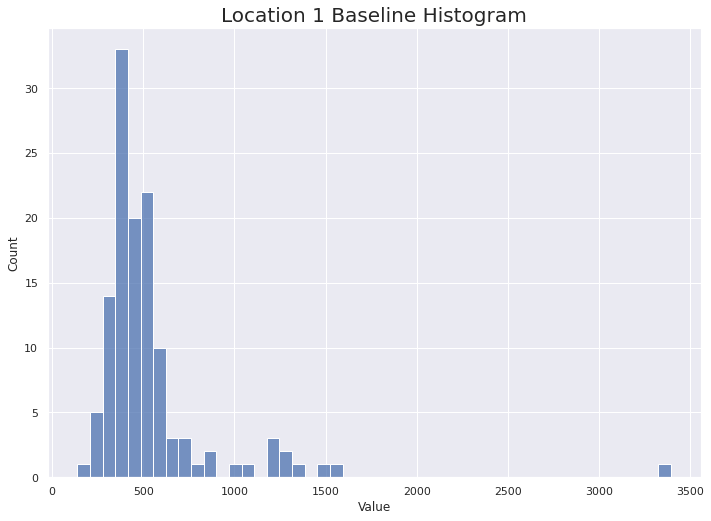

In [140]:
# Visualise Baseline values
# Location 1
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data=df_data_L1[df_data_L1['Time']==0],x='Value').set_title('Location 1 Baseline Histogram',fontsize=20)


Text(0.5, 1.0, 'Location 2 Baseline Histogram')

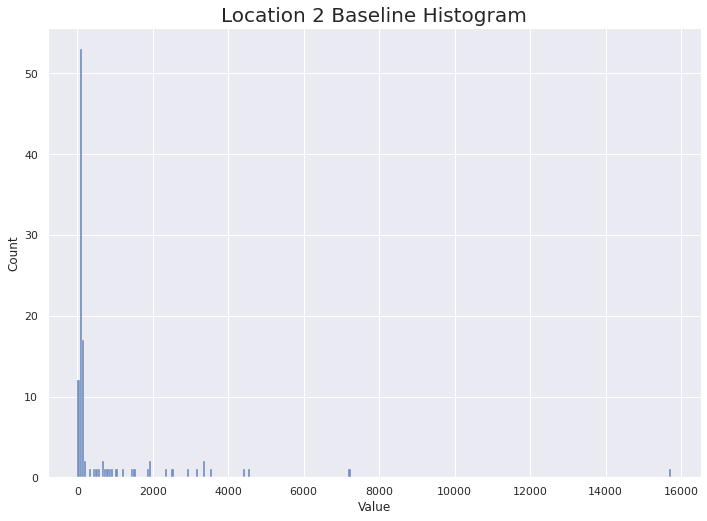

In [141]:
# Location 2

sns.histplot(data=df_data_L2[df_data_L2['Time']==0],x='Value').set_title('Location 2 Baseline Histogram',fontsize=20)

### Data Cleaning and Wrangling
A quick glance shows the length of data per patient is not consistent. Time to clean this data.

In [142]:
## Remove any patient entries with blank or zero values
# PatientID's with empty values
missing_data = df_data.loc[pd.isna(df_data['Value']),'PatientID']

# PatientID's with 0 values
zero_data  = df_data.loc[df_data['Value'] == 0,'PatientID']

# Combine list of PatientID's and drop any duplicates to reduce search time
drop_data = pd.concat([missing_data,zero_data]).drop_duplicates()

df_clean = df_data[(~df_data['PatientID'].isin(drop_data))]
df_clean['PatientID'].nunique()

118

We have reduced down to 118 unique patients. 

In [143]:
# Create a unique column identifier for joining to avoid many to many relationships
df_clean['join_var'] = df_clean.loc[:,'PatientID'].apply(str) + '_' + df_clean.loc[:,'Time'].apply(str)

# Split the clean data into Loc1 and Loc2 and join them together such that the data is pivoted
df_clean_loc1 = df_clean[df_clean['Location'] == 'Loc1'].drop(['Location'],axis=1)
df_clean_loc1.rename(columns={'Time':'TL1',
                              'Value':'VL1'},
                     inplace=True)

df_clean_loc2 = df_clean[df_clean['Location'] == 'Loc2']
df_clean_loc2.rename(columns={'Time':'TL2',
                              'Value':'VL2'},
                     inplace=True)
# Drop columns to remove duplicate PatientID Column
df_clean_loc2_join = df_clean_loc2.drop(['Location','PatientID'],axis=1)


df_clean_joined = pd.merge(df_clean_loc1,df_clean_loc2_join,how='left',on='join_var').drop(['join_var'],axis=1)
df_clean_joined.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PatientID,TL1,VL1,TL2,VL2
0,2,0,1288.334928,0,72.806172
1,2,3,1219.907629,3,70.319241
2,2,5,1085.585193,5,62.295082
3,2,14,476.519809,14,16.393443
4,2,17,1054.249202,17,57.984214


Export this data for exploratory visualisation (Scale of graphs matter - The turning point)

In [144]:
df_clean.to_csv(path_home+'/data_cleaned.csv',index=False)
df_clean_joined.to_csv(path_home+'/data_cleaned_unstacked.csv',index=False)

### Post Data Visualisation
Having seen the data visualised, it was good to see there was definitely a similarity between some responses but it was clear that there was some data manipulation that would be required to explore the possibilities of correlations between location 1 and 2.

##### Standardisation vs Normalisation
From inspection of the data in Loc 1 and 2 within some patients, I observed that some responses had an extremely large range and magnitude of response. For example Patient ID 122:

In [145]:
p122 = df_clean_joined[df_clean_joined['PatientID'] == 122]
p122[['PatientID','VL1','VL2']]

,PatientID,VL1,VL2
573,122,368.041325,15731.557380
574,122,341.792301,4020.491803
575,122,352.117486,133.196721
576,122,396.772541,125.000000
577,122,381.662165,2355.971897
578,122,384.409398,1697.619343


In [146]:
p122[['PatientID','VL1','VL2']].describe()

,PatientID,VL1,VL2
count,6.0,6.000000,6.000000
mean,122.0,370.799203,4010.639524
std,0.0,20.860817,5926.225729
min,122.0,341.792301,125.000000
25%,122.0,356.098446,524.302377
50%,122.0,374.851745,2026.795620
75%,122.0,383.722589,3604.361827
max,122.0,396.772541,15731.557380


From inspection we can consider that although the range is much larger in magnitude for Loc 2 than Loc 1, the values within Loc 2 are relatively in scale. However since the range is large, this would suffer from normalisation as other values will become very small. Therefore I will choose to standardise the data instead of normalise.

First I will calculate the mean and std of each patient's data within for location 1 and 2 separately

In [147]:
# Create Dataframe with two columns of VL1 for calculation of mean and standard deviation within columns via groupby-agg functions.
df_patient_stats_L1 = df_clean_loc1.loc[:,['PatientID','VL1']]
df_patient_stats_L1['std_VL1'] = df_patient_stats_L1['VL1']
df_patient_stats_L1['max_VL1'] = df_patient_stats_L1['VL1']
df_patient_stats_L1['min_VL1'] = df_patient_stats_L1['VL1']
df_patient_stats_L1['t0_VL1'] = df_patient_stats_L1['VL1']

# Rename to appropriate names
df_patient_stats_L1.rename(columns={'VL1':'mean_VL1'},inplace=True)
df_patient_stats_L1.head()

,PatientID,mean_VL1,std_VL1,max_VL1,min_VL1,t0_VL1
1,2,1288.334928,1288.334928,1288.334928,1288.334928,1288.334928
3,2,1219.907629,1219.907629,1219.907629,1219.907629,1219.907629
5,2,1085.585193,1085.585193,1085.585193,1085.585193,1085.585193
7,2,476.519809,476.519809,476.519809,476.519809,476.519809
9,2,1054.249202,1054.249202,1054.249202,1054.249202,1054.249202


In [148]:
# Groupby and Aggregate by the mean and sample standard deviation formula
df_patient_stats_L1 = df_patient_stats_L1.groupby(['PatientID'], as_index=False).agg({'mean_VL1':'mean',
                                                                                      'std_VL1':'std',
                                                                                      'max_VL1':'max',
                                                                                      'min_VL1':'min',
                                                                                      't0_VL1':'first'})
df_patient_stats_L1['range_VL1'] = df_patient_stats_L1['max_VL1'] - df_patient_stats_L1['min_VL1']
df_patient_stats_L1

,PatientID,mean_VL1,std_VL1,max_VL1,min_VL1,t0_VL1,range_VL1
0,2,890.260862,261.468201,1288.334928,410.946038,1288.334928,877.388890
1,3,345.750321,44.586892,412.226776,298.582650,412.226776,113.644126
2,4,613.818033,135.174634,794.204881,433.145492,794.204881,361.059389
3,5,429.947778,79.937401,525.560614,326.037046,525.560614,199.523568
4,6,368.914124,51.082111,416.922814,315.232240,315.232240,101.690574
...,...,...,...,...,...,...,...
113,143,264.874646,20.756609,285.586100,221.949854,277.038522,63.636246
114,144,328.590710,88.509772,457.956545,262.070569,266.998163,195.885975
115,145,253.744049,41.998242,283.441291,224.046808,283.441291,59.394483
116,147,590.069504,116.049537,684.531822,390.866640,390.866640,293.665182


In [149]:
# Do the same for Loc2:
# Create Dataframe with two columns of VL1 for calculation of mean and standard deviation within columns via groupby-agg functions.
df_patient_stats_L2 = df_clean_loc2.loc[:,['PatientID','VL2']]
df_patient_stats_L2['std_VL2'] = df_patient_stats_L2['VL2']
df_patient_stats_L2['min_VL2'] = df_patient_stats_L2['VL2']
df_patient_stats_L2['max_VL2'] = df_patient_stats_L2['VL2']
df_patient_stats_L2['t0_VL2'] = df_patient_stats_L2['VL2']

# Rename to appropriate names
df_patient_stats_L2.rename(columns={'VL2':'mean_VL2'},inplace=True)
df_patient_stats_L2 = df_patient_stats_L2.groupby(['PatientID'], as_index=False).agg({'mean_VL2':'mean',
                                                                                      'std_VL2':'std',
                                                                                      'max_VL2':'max',
                                                                                      'min_VL2':'min',
                                                                                      't0_VL2':'first'})
df_patient_stats_L2['range_VL2'] = df_patient_stats_L2['max_VL2'] - df_patient_stats_L2['min_VL2']
df_patient_stats_L2

,PatientID,mean_VL2,std_VL2,max_VL2,min_VL2,t0_VL2,range_VL2
0,2,183.353486,138.610139,376.408812,16.393443,72.806172,360.015369
1,3,27.808826,7.216701,38.934426,16.393443,38.934426,22.540984
2,4,34.191340,15.222755,66.598361,22.540984,66.598361,44.057377
3,5,1438.608082,1727.878238,4398.908330,80.371524,4398.908330,4318.536806
4,6,66.370674,11.763385,79.918033,58.743169,58.743169,21.174863
...,...,...,...,...,...,...,...
113,143,135.033939,12.503975,156.383118,117.275937,156.383118,39.107181
114,144,70.536015,16.887951,88.758659,53.451028,53.451028,35.307631
115,145,101.717183,7.946281,107.336052,96.098315,96.098315,11.237738
116,147,137.583308,15.986556,152.499814,107.162031,107.162031,45.337783


Now that we have calculated means and standard deviations for all patients within each location, we can join these stats onto the data and standardise the data.

In [150]:
df_clean_data_L1 = pd.merge(df_clean_loc1,df_patient_stats_L1,how='left',on='PatientID')
df_clean_data_L1

,PatientID,TL1,VL1,join_var,mean_VL1,std_VL1,max_VL1,min_VL1,t0_VL1,range_VL1
0,2,0,1288.334928,2_0,890.260862,261.468201,1288.334928,410.946038,1288.334928,877.388890
1,2,3,1219.907629,2_3,890.260862,261.468201,1288.334928,410.946038,1288.334928,877.388890
2,2,5,1085.585193,2_5,890.260862,261.468201,1288.334928,410.946038,1288.334928,877.388890
3,2,14,476.519809,2_14,890.260862,261.468201,1288.334928,410.946038,1288.334928,877.388890
4,2,17,1054.249202,2_17,890.260862,261.468201,1288.334928,410.946038,1288.334928,877.388890
...,...,...,...,...,...,...,...,...,...,...
698,148,7,515.395375,148_7,425.190695,75.481902,515.395375,313.507384,515.395375,201.887992
699,148,21,313.507384,148_21,425.190695,75.481902,515.395375,313.507384,515.395375,201.887992
700,148,77,468.854918,148_77,425.190695,75.481902,515.395375,313.507384,515.395375,201.887992
701,148,79,417.796489,148_79,425.190695,75.481902,515.395375,313.507384,515.395375,201.887992


In [151]:
# Normalise to 0 - 1
df_clean_data_L1['VL1_norm'] = (df_clean_data_L1['VL1'] - df_clean_data_L1['min_VL1'])/df_clean_data_L1['range_VL1']
# Normalise to the baseline t0 by subtracting initial value
df_clean_data_L1['VL1_norm_t0'] = df_clean_data_L1['VL1'] - df_clean_data_L1['t0_VL1']
# Standardise using mean and std ((x - mean)/std)
df_clean_data_L1['VL1_standard'] = (df_clean_data_L1['VL1'] - df_clean_data_L1['mean_VL1'])/df_clean_data_L1['std_VL1']

df_clean_data_L1

,PatientID,TL1,VL1,join_var,mean_VL1,std_VL1,max_VL1,min_VL1,t0_VL1,range_VL1,VL1_norm,VL1_norm_t0,VL1_standard
0,2,0,1288.334928,2_0,890.260862,261.468201,1288.334928,410.946038,1288.334928,877.388890,1.000000,0.000000,1.522457
1,2,3,1219.907629,2_3,890.260862,261.468201,1288.334928,410.946038,1288.334928,877.388890,0.922010,-68.427299,1.260753
2,2,5,1085.585193,2_5,890.260862,261.468201,1288.334928,410.946038,1288.334928,877.388890,0.768917,-202.749735,0.747029
3,2,14,476.519809,2_14,890.260862,261.468201,1288.334928,410.946038,1288.334928,877.388890,0.074737,-811.815119,-1.582376
4,2,17,1054.249202,2_17,890.260862,261.468201,1288.334928,410.946038,1288.334928,877.388890,0.733202,-234.085726,0.627183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,148,7,515.395375,148_7,425.190695,75.481902,515.395375,313.507384,515.395375,201.887992,1.000000,0.000000,1.195050
699,148,21,313.507384,148_21,425.190695,75.481902,515.395375,313.507384,515.395375,201.887992,0.000000,-201.887992,-1.479604
700,148,77,468.854918,148_77,425.190695,75.481902,515.395375,313.507384,515.395375,201.887992,0.769474,-46.540457,0.578473
701,148,79,417.796489,148_79,425.190695,75.481902,515.395375,313.507384,515.395375,201.887992,0.516569,-97.598886,-0.097960


In [152]:
# Repeat for Location 2
# Left join data to Loc 2
df_clean_data_L2 = pd.merge(df_clean_loc2,df_patient_stats_L2,how='left',on='PatientID')
# Normalise to 0 - 1
df_clean_data_L2['VL2_norm'] = (df_clean_data_L2['VL2'] - df_clean_data_L2['min_VL2'])/df_clean_data_L2['range_VL2']
# Normalise to the baseline t0 by subtracting initial value
df_clean_data_L2['VL2_norm_t0'] = df_clean_data_L2['VL2'] - df_clean_data_L2['t0_VL2']
# Standardise using mean and std ((x - mean)/std)
df_clean_data_L2['VL2_standard'] = (df_clean_data_L2['VL2'] - df_clean_data_L2['mean_VL2'])/df_clean_data_L2['std_VL2']
df_clean_data_L2

,PatientID,TL2,Location,VL2,join_var,mean_VL2,std_VL2,max_VL2,min_VL2,t0_VL2,range_VL2,VL2_norm,VL2_norm_t0,VL2_standard
0,2,0,Loc2,72.806172,2_0,183.353486,138.610139,376.408812,16.393443,72.806172,360.015369,0.156695,0.000000,-0.797541
1,2,3,Loc2,70.319241,2_3,183.353486,138.610139,376.408812,16.393443,72.806172,360.015369,0.149787,-2.486931,-0.815483
2,2,5,Loc2,62.295082,2_5,183.353486,138.610139,376.408812,16.393443,72.806172,360.015369,0.127499,-10.511090,-0.873373
3,2,14,Loc2,16.393443,2_14,183.353486,138.610139,376.408812,16.393443,72.806172,360.015369,0.000000,-56.412729,-1.204530
4,2,17,Loc2,57.984214,2_17,183.353486,138.610139,376.408812,16.393443,72.806172,360.015369,0.115525,-14.821958,-0.904474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,148,7,Loc2,107.075232,148_7,113.479761,6.144253,119.341403,106.988574,107.075232,12.352829,0.007015,0.000000,-1.042361
699,148,21,Loc2,106.988574,148_21,113.479761,6.144253,119.341403,106.988574,107.075232,12.352829,0.000000,-0.086658,-1.056465
700,148,77,Loc2,114.904438,148_77,113.479761,6.144253,119.341403,106.988574,107.075232,12.352829,0.640814,7.829206,0.231872
701,148,79,Loc2,119.341403,148_79,113.479761,6.144253,119.341403,106.988574,107.075232,12.352829,1.000000,12.266171,0.954004


In [153]:
# Join and write out
# Remove columns prior to merging
df_clean_data_L2_merge = df_clean_data_L2.drop(['PatientID','TL2','Location'],axis=1)

# Join
df_clean_out = pd.merge(df_clean_data_L1,df_clean_data_L2_merge,how='left',on='join_var')

# Drop stats columns
df_out = df_clean_out.drop(['mean_VL1','std_VL1','max_VL1','min_VL1','t0_VL1','range_VL1',
                   'mean_VL2','std_VL2','max_VL2','min_VL2','t0_VL2','range_VL2'],axis=1)
df_out.to_csv(path_home+'/data_std_norm.csv',index=False)

##### Upsampling
Since we are interested within t0-15 and many data points are missing. We will attempt to upsample patient data by resampling and interpolating using a 2nd-order spline.

This interpolation is purely for the purpose of achieving some numerical values within the t0-15 window.

Below is an example of the upsampling method used for a given patient.

Text(0.5, 0, 'Time')

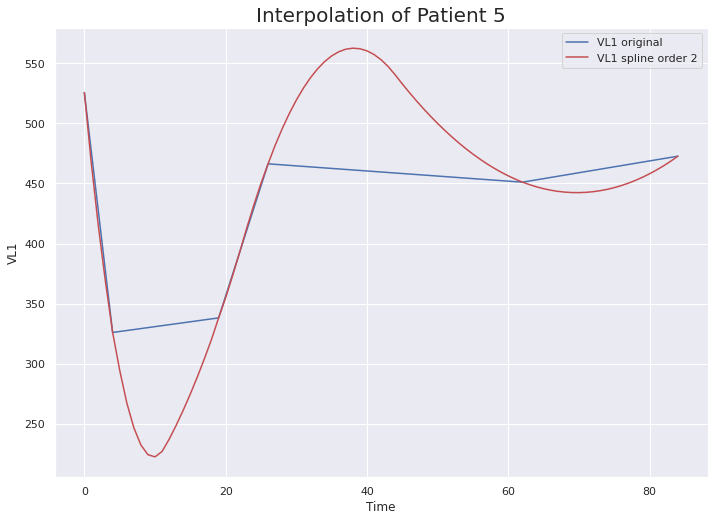

In [154]:
# Upsampling of data
# Select patient id
patient_id = 5
patient = df_clean_joined[df_clean_joined['PatientID'] == patient_id]

# Set the time as the index
patient_L1 = patient[['TL1','VL1']].set_index('TL1')
# Find the min and max range of the index's available
min_range = min(patient_L1.index)
max_range = max(patient_L1.index) + 1

# Upsample
# Reindex and fill with NA values for times missing
patient_L1_upsample = patient_L1.reindex(index=range(min_range,max_range),fill_value=np.nan)

# Interpolate using a 2nd-order spline
patient_L1_interp = patient_L1_upsample.interpolate(method='spline',order=2)

# Plot
plt.plot(patient_L1,'b',label='VL1 original')
plt.plot(patient_L1_interp,'r',label='VL1 spline order 2')
plt.legend()
plt.title('Interpolation of Patient ' + str(patient_id),fontsize=20)
plt.ylabel('VL1')
plt.xlabel('Time')

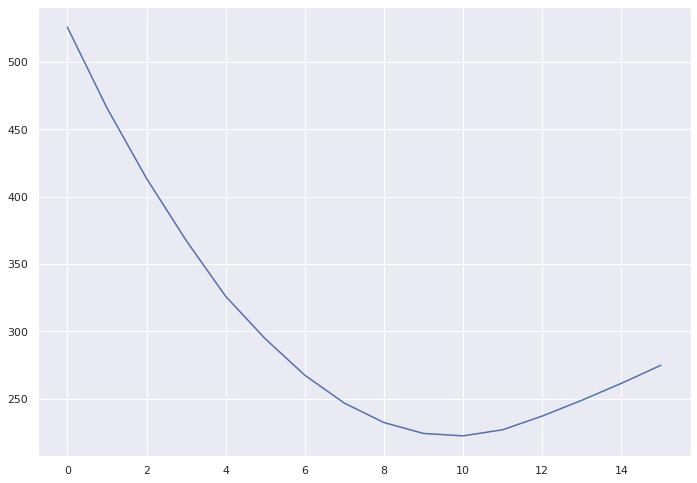

In [155]:
# We then only want to capture t0 - 15.
plt.plot(patient_L1_interp.iloc[0:16])

We will now repeat this process for all patients with a max Time value greater than 15. Adding each patient as a new column to a final results dataframe which we can do a pairwise correlation.

In [156]:
# Create Patient List
patient_list = df_clean_joined['PatientID'].unique()
patient_list

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  12,  13,  15,  17,
        18,  19,  20,  23,  24,  25,  27,  28,  29,  30,  31,  32,  34,
        35,  36,  37,  38,  43,  44,  45,  46,  47,  48,  49,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  69,  70,  71,  72,  73,  74,  76,  77,  79,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  95,  96,  97,
        98,  99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 114, 116, 119, 120, 122, 123, 126, 127, 128, 129, 130, 132,
       133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147,
       148])

In [157]:
# Initiate Empty Dataframes
df_loc1_results = pd.DataFrame()
df_loc2_results = pd.DataFrame()

In [158]:
# Iterate over the patient list and perform this operation on each if they have 
# a time starting at 0 and ending above 15
for id in patient_list:
  patient = df_clean_joined[df_clean_joined['PatientID'] == id]
  
  # Split the data into Loc1 and Loc2  and set the time as the index
  patient_L1 = patient[['TL1','VL1']].set_index('TL1')
  patient_L2 = patient[['TL2','VL2']].set_index('TL2')

  # Find index time ranges (L1 and L2 have same indexes)
  min_range = min(patient_L1.index)
  max_range = max(patient_L1.index) + 1
  
  n_samples = len(patient_L1.index)

  if min_range == 0 and max_range >= 16 and n_samples >= 5:
    patient_L1_upsample = patient_L1.reindex(index=range(min_range,max_range),fill_value=np.nan)
    patient_L2_upsample = patient_L2.reindex(index=range(min_range,max_range),fill_value=np.nan)

    # Interpolate using a 2nd-order spline
    patient_L1_interp = patient_L1_upsample.interpolate(method='spline',order=2)
    patient_L2_interp = patient_L2_upsample.interpolate(method='spline',order=2)

    # Assign data to new column
    df_loc1_results['new_result'] = patient_L1_interp['VL1'].iloc[0:16]
    df_loc2_results['new_result'] = patient_L2_interp['VL2'].iloc[0:16]

    # Rename column to ID
    df_loc1_results.rename(columns={'new_result':'patient_'+str(id)}, inplace=True)
    df_loc2_results.rename(columns={'new_result':'patient_'+str(id)}, inplace=True)

# Write out data
df_loc1_results.to_csv(path_home+'/location1_t0_15_interpolation.csv',index=False)
df_loc2_results.to_csv(path_home+'/location2_t0_15_interpolation.csv',index=False)
df_loc1_results

/usr/local/lib/python3.6/dist-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp

,patient_2,patient_3,patient_4,patient_5,patient_12,patient_15,patient_17,patient_18,patient_19,patient_20,patient_23,patient_24,patient_27,patient_28,patient_34,patient_35,patient_37,patient_38,patient_43,patient_44,patient_45,patient_46,patient_47,patient_48,patient_49,patient_51,patient_52,patient_53,patient_54,patient_55,patient_56,patient_57,patient_58,patient_59,patient_60,patient_61,patient_62,patient_63,patient_64,patient_65,...,patient_89,patient_90,patient_91,patient_92,patient_95,patient_96,patient_97,patient_98,patient_99,patient_101,patient_102,patient_103,patient_104,patient_105,patient_107,patient_108,patient_109,patient_110,patient_111,patient_112,patient_114,patient_116,patient_119,patient_120,patient_122,patient_123,patient_126,patient_127,patient_128,patient_129,patient_130,patient_132,patient_133,patient_136,patient_138,patient_139,patient_140,patient_141,patient_142,patient_143
TL1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1288.334928,412.226776,794.204881,525.560614,595.389344,511.469718,699.419070,411.458333,615.515640,380.952381,436.418488,1047.897528,259.560668,437.879689,435.835041,454.192369,542.169157,357.923497,453.694217,513.316928,459.019997,401.075820,528.870674,583.570507,609.652739,336.699776,643.649980,399.201199,481.636192,559.709652,389.477027,404.872495,523.890027,458.523849,709.569658,515.787227,463.473595,537.620915,552.049180,1469.729527,...,510.880273,1260.002826,539.957644,416.480834,425.408887,492.477831,449.629890,380.082869,460.528884,515.698185,415.880113,1588.214425,537.088029,1337.978531,1202.327622,389.813866,543.920765,401.614949,449.492179,1220.705664,375.014638,605.956447,349.013358,757.007237,368.041325,234.076161,226.829320,518.169399,497.584386,387.182030,867.811394,399.134790,469.271723,139.173497,296.035405,530.652322,292.824505,286.244445,469.415984,277.038522
1,1284.272191,351.671703,654.812017,465.714646,535.722730,375.256147,638.288365,341.575257,582.078212,377.997875,428.964068,1018.991652,258.578345,365.894579,443.877151,390.070160,479.266232,325.676136,418.832611,427.452174,455.753610,389.538982,518.036944,577.113996,356.992307,327.411263,551.838013,394.303546,483.152385,542.253265,357.067312,342.007909,426.081889,452.169866,579.809486,394.010749,376.014260,429.162719,605.362022,1386.370622,...,500.170765,769.822740,360.669802,419.775544,411.074592,461.377246,439.233322,369.109184,410.236173,436.268459,415.880113,982.579768,526.979191,824.054634,1008.089396,406.823283,491.241497,420.319862,432.166326,1234.924585,421.495835,602.976378,357.606452,684.630622,352.688546,219.121533,253.516133,524.041717,463.074455,364.013370,862.879137,344.704648,463.239470,134.974413,298.325240,554.023000,288.080250,250.646632,357.060041,243.570171
2,1261.750740,319.614664,548.580378,413.472793,467.577114,319.668765,247.353142,302.530582,569.367914,332.658609,423.444009,994.667578,252.635537,325.368282,450.127823,359.010688,430.544051,312.040801,390.898224,372.950820,447.375219,379.185449,501.681222,571.019229,306.267077,318.709915,474.381279,390.098084,481.848858,525.329081,330.115128,297.195952,360.741120,443.585429,477.760480,375.512295,313.609973,346.341217,691.598361,1283.457904,...,495.400918,363.094411,273.907104,420.969945,399.175749,435.675533,432.618286,359.457845,365.437159,381.830601,321.209016,616.888661,516.863046,445.952869,925.713123,288.560529,444.228948,424.351950,418.570119,1239.216143,428.903489,598.551189,355.312140,652.497892,341.792301,224.089097,273.181353,528.198622,433.829698,343.257937,859.678753,298.675459,458.664784,136.014344,300.749232,574.538934,283.314505,229.607892,278.859290,221.949854
3,1219.907629,313.695355,475.062089,367.537834,408.952281,328.058652,-15.620148,286.078894,570.423976,290.300546,416.790859,979.958428,241.555311,322.019764,457.735656,358.606557,393.271858,314.463798,373.942358,354.006129,434.207357,371.670082,475.253197,565.438139,355.889364,315.138772,410.205673,386.440396,478.105047,508.858

### Data Analysis

##### Patient to Patient pair-wise correlation
We hope by using patient to patient pair-wise correlation that we can see that across patients there is a systematic response within the t0-t15 time frame.

If there is a high distribution of positive correlations across all data then there is most likely a trend that is present in the population.

In [159]:
df_loc1_patient_corr = df_loc1_results.corr()
df_loc2_patient_corr = df_loc2_results.corr()

Text(0.5, 1.0, 'Location 1 Patient to Patient Correlation Matrix Heatmap')

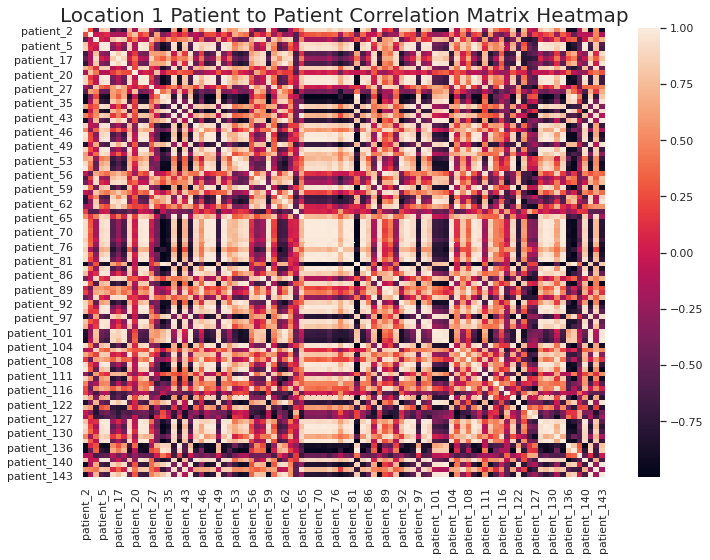

In [160]:
sns.heatmap(df_loc1_patient_corr).set_title('Location 1 Patient to Patient Correlation Matrix Heatmap',fontsize=20)

Text(0.5, 1.0, 'Location 2 Patient to Patient Correlation Matrix Heatmap')

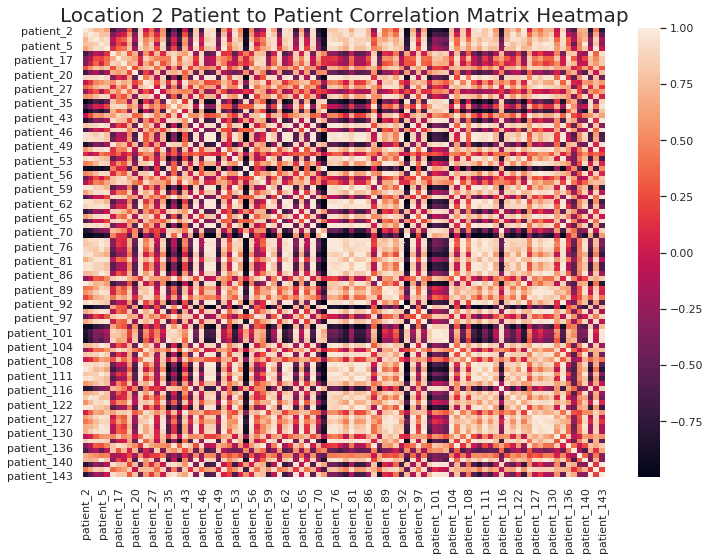

In [161]:
sns.heatmap(df_loc2_patient_corr).set_title('Location 2 Patient to Patient Correlation Matrix Heatmap',fontsize=20)

In [162]:
# Take the upper triangle of the matrices for analysis of correlations
df_loc1_pair_corr = df_loc1_patient_corr.where(np.triu(np.ones(df_loc1_patient_corr.shape)).astype(np.bool))
df_loc1_pair_corr = df_loc1_pair_corr.stack().reset_index()
df_loc1_pair_corr.columns = ['Row','Column','Correlation Coefficient']

df_loc2_pair_corr = df_loc2_patient_corr.where(np.triu(np.ones(df_loc2_patient_corr.shape)).astype(np.bool))
df_loc2_pair_corr = df_loc2_pair_corr.stack().reset_index()
df_loc2_pair_corr.columns = ['Row','Column','Correlation Coefficient']
df_loc2_pair_corr

,Row,Column,Correlation Coefficient
0,patient_2,patient_2,1.000000
1,patient_2,patient_3,0.889321
2,patient_2,patient_4,0.723135
3,patient_2,patient_5,0.774556
4,patient_2,patient_12,0.623002
...,...,...,...
4460,patient_141,patient_142,0.146637
4461,patient_141,patient_143,0.995152
4462,patient_142,patient_142,1.000000
4463,patient_142,patient_143,0.204841


In [163]:
# Remove the self correlations
self_corr_loc1 = df_loc1_pair_corr['Row'] == df_loc1_pair_corr['Column']
self_corr_loc2 = df_loc2_pair_corr['Row'] == df_loc2_pair_corr['Column']

df_loc1_pair_corr_no_self = df_loc1_pair_corr.loc[~self_corr_loc1]
df_loc2_pair_corr_no_self = df_loc2_pair_corr.loc[~self_corr_loc2]

In [164]:
df_loc1_pair_corr_no_self.describe()

,Correlation Coefficient
count,4371.000000
mean,0.159416
std,0.639631
min,-0.999915
25%,-0.428573
50%,0.232860
75%,0.788404
max,0.999838


Text(0.5, 1.0, 'Correlation Coefficient Distribution for Location 1, Pairwise Patient Correlation')

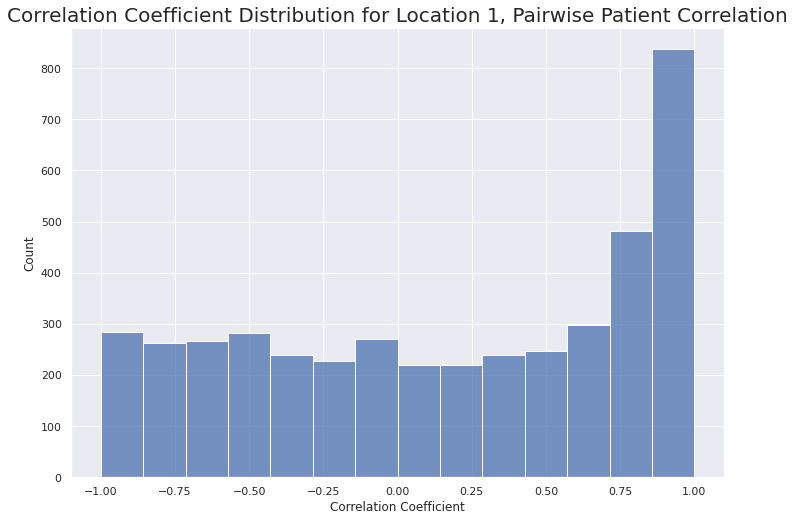

In [165]:
sns.histplot(df_loc1_pair_corr_no_self,x='Correlation Coefficient').set_title('Correlation Coefficient Distribution for Location 1, Pairwise Patient Correlation',fontsize=20)

Text(0.5, 1.0, 'Correlation Coefficient Distribution for Location 2, Pairwise Patient Correlation')

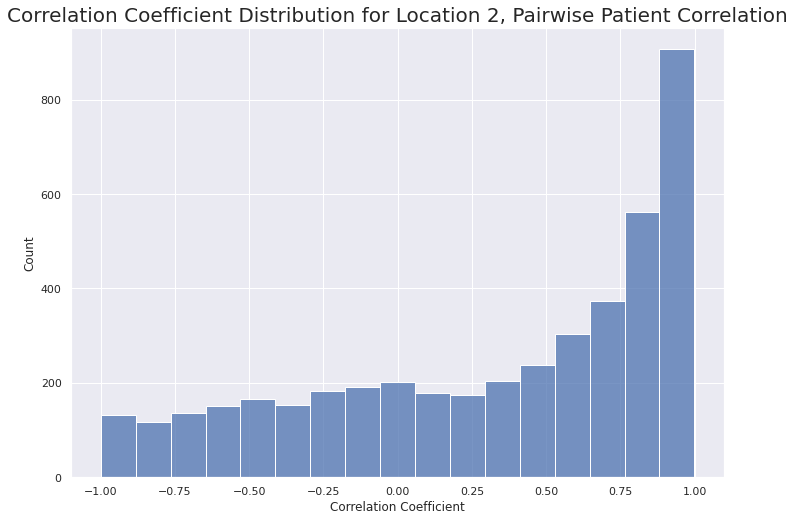

In [166]:
sns.histplot(df_loc2_pair_corr_no_self,x='Correlation Coefficient').set_title('Correlation Coefficient Distribution for Location 2, Pairwise Patient Correlation',fontsize=20)

##### Cross correlation within patients across location
Cross correlation can be used to determine the similarities between signals. In this case we are trying to determine whether or not the measured response at location 1 and 2 are similar. If there is a correlation between location 1 and 2, then that means there is a similarity in the response with respect to time (higher correlation, more allignment). 

Due to the low resolution of the data, this will unfortunately be euclidean matching

In [167]:
df_corr_data = df_clean_joined.loc[:,['PatientID','VL1','VL2']]
df_corr_data

,PatientID,VL1,VL2
0,2,1288.334928,72.806172
1,2,1219.907629,70.319241
2,2,1085.585193,62.295082
3,2,476.519809,16.393443
4,2,1054.249202,57.984214
...,...,...,...
698,148,515.395375,107.075232
699,148,313.507384,106.988574
700,148,468.854918,114.904438
701,148,417.796489,119.341403


In [168]:
patient_id = 103
patient_rows = df_corr_data['PatientID'] == patient_id
vl1 = (df_corr_data.loc[patient_rows,'VL1'])
vl2 = (df_corr_data.loc[patient_rows,'VL2'])

corr = vl1.corr(vl2)
corr

0.998780440939253

It goes without saying that for two signals that visually allign and match there will be strong correlations. We can shift the Location 2 signal and recalculate the correlation (Shifted by position, although it would be more accurate to have some interpolation of the data between points and shit by time as opposed to position in the matrix as this disregards time interval differences)

In [169]:
shift_corr_1 = vl1.corr(vl2.shift(1))
shift_corr_1

-0.8447820276792017

Given this idea, across all patients we will calculate the correlation with shifts -1, 0 and +1 spaces of Loc2 to Loc1. Shifting positionally however causes the presence of NA values to fill in on the sides of the data. We cannot extrapolate the ends of the data and so we will proceed with calculating the correlation between Loc 1 and 2 so long as NA values do not become the majority of the data. This is why i've chosen a shift of +/-1. 

Since we are shifting, I will only use Patients with atleast 5 data points as any lower will produce insignificant data.

In [170]:
patient_list = df_clean_joined['PatientID'].unique()
patient_list

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  12,  13,  15,  17,
        18,  19,  20,  23,  24,  25,  27,  28,  29,  30,  31,  32,  34,
        35,  36,  37,  38,  43,  44,  45,  46,  47,  48,  49,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  69,  70,  71,  72,  73,  74,  76,  77,  79,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  95,  96,  97,
        98,  99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 114, 116, 119, 120, 122, 123, 126, 127, 128, 129, 130, 132,
       133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147,
       148])

In [171]:
# Function to calculate correlation with shifts
def cross_corr(loc1,loc2,lag=0):
  ''' Lag-N cross correlation calculating function
  Data that is shifted is filled with NaNs

  Parameters
  ----------
  lag : int, default 0
  loc1, loc2 : pandas.Series objects of equal length

  Returns
  ----------
  crosscorr: float
  '''
  return loc1.corr(loc2.shift(lag))

In [172]:
col_names = ['PatientID','n_samples','corr_minus1','corr_zero','corr_plus1']

df_results = pd.DataFrame(columns=col_names)

for id in patient_list:
  # Calculate number of samples per patient
  patient_rows = df_clean_joined['PatientID'] == id
  n_samples = len(df_clean_joined.loc[patient_rows,:])
  # If more than 5 samples
  if n_samples >= 5:
    
    vl1 = df_clean_joined.loc[patient_rows,'VL1']
    vl2 = df_clean_joined.loc[patient_rows,'VL2']
    
    corr_m1 = cross_corr(vl1,vl2,lag=-1) 
    corr_zero = cross_corr(vl1,vl2,lag=0)
    corr_p1 = cross_corr(vl1,vl2,lag=1)
    
    # Append results
    results_data = {'PatientID':[id],
                    'n_samples':[n_samples],
                    'corr_minus1':[corr_m1],
                    'corr_zero':[corr_zero],
                    'corr_plus1':[corr_p1]}
    record = pd.DataFrame(data=results_data)
    df_results = pd.concat([df_results,record])

df_results

,PatientID,n_samples,corr_minus1,corr_zero,corr_plus1
0,2,12,-0.337656,-0.011609,-0.478221
0,3,6,-0.452084,0.881678,-0.102756
0,4,7,-0.075237,0.377282,-0.415762
0,5,6,-0.363007,0.812278,-0.496483
0,10,5,0.161403,0.699802,0.460577
...,...,...,...,...,...
0,142,7,0.024267,0.846551,0.490109
0,143,7,-0.236036,0.764484,-0.757044
0,144,5,0.620942,0.937072,0.838376
0,147,6,-0.358440,0.960847,-0.271737


In [173]:
df_results.describe()

,corr_minus1,corr_zero,corr_plus1
count,98.000000,98.000000,98.000000
mean,-0.007116,0.484429,0.032137
std,0.495612,0.521509,0.533301
min,-0.942795,-0.944145,-0.974203
25%,-0.363150,0.062235,-0.393516
50%,0.005632,0.724192,0.052225
75%,0.328108,0.921519,0.472061
max,0.978954,0.998780,0.991796


Text(0.5, 1.0, 'Location Correlation with Shift = -1')

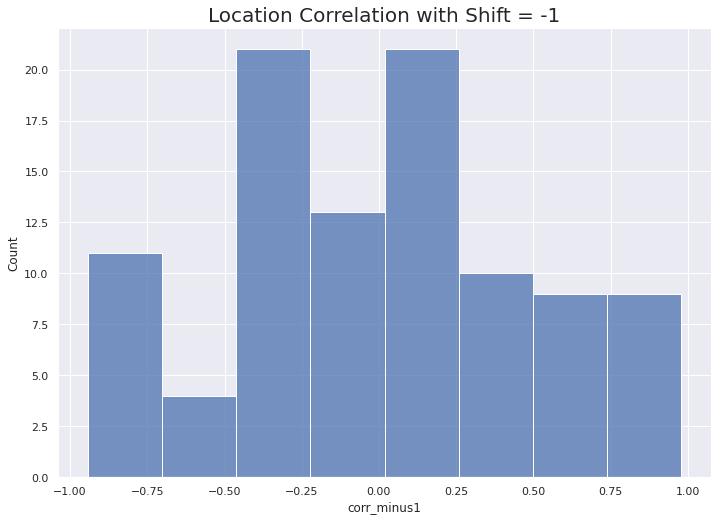

In [174]:
sns.histplot(data = df_results, x='corr_minus1').set_title('Location Correlation with Shift = -1',fontsize=20)

Text(0.5, 1.0, 'Location Correlation with Shift = 0')

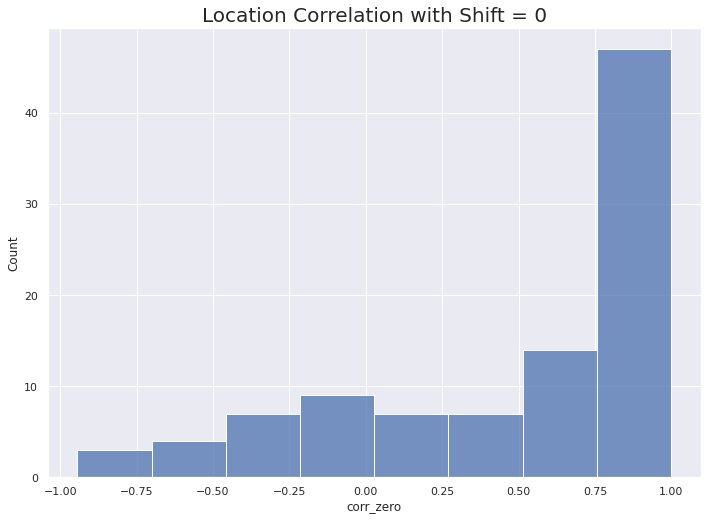

In [175]:
sns.histplot(data = df_results, x='corr_zero').set_title('Location Correlation with Shift = 0',fontsize=20)

Text(0.5, 1.0, 'Location Correlation with Shift = +1')

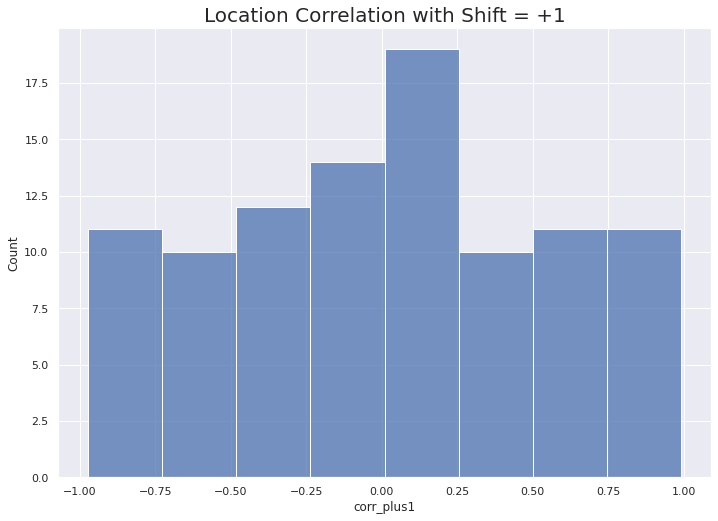

In [176]:
sns.histplot(data = df_results, x='corr_plus1').set_title('Location Correlation with Shift = +1',fontsize=20)